# Trying out regression methods in Python

This notebook shows how to use a few regression methods in Python.

In [152]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from astroML.linear_model import NadarayaWatson
import statsmodels.api as sm
import scipy.stats as stats
%matplotlib inline

I will use seaborn as my visualisation choice, but I want to modify the settings slightly to make the grid and plot area a bit less in-your-face

In [153]:
sns.set_context('talk')
sns.set_style('whitegrid', {"grid.color": ".95", 'grid.linestyle': u'-'})
sns.set_palette('colorblind')

In [154]:
def fake_func(x):
    return np.sin(x*3.0)*(x-6)**4/1e3 + 0.1*x + 0.04*(x-4.5)**2

def make_fake_data():
    """
    Create some data from $y = 0.001*sin(3 x)*(x-6)^2 + 0.1*x + 0.04*(x-4.5)^2$.
    """
    
    np.random.seed(15)
    
    n_samples = 7
    
    x = np.random.uniform(0, 6, 15)
    x.sort()
    
    y = fake_func(x)
    
    # And finally add some noise
    dy = 1.0/3.0
    y = y + np.random.normal(0, dy, len(y))
    
    return x, y, dy

def plot_a_fit(x, y, xest, yest, include_true=False, ax=None, dy=None, dyest=None):
    """
    Plot the result of a fit to the fake data. This is put in as a function
    to speed things up below.
    """
    
    if ax is None:
        ax = plt.gca()
        
    ax.scatter(x, y, 150, marker='.')
    
    if dyest is not None:
        # The user provided a confidence interval on the estimates.
        # I will use a 2sigma interval.
        ax.plot(xest, yest, '-k')
        y_low = yest - 1.96*dyest
        y_high = yest + 1.96*dyest
        ax.fill_between(xest, y_low, y_high, alpha=0.2, color='r')

    if dy is not None:
        # Data errorbars
        ax.errorbar(x, y, dy, fmt='.k', ecolor='gray', markersize=8)       
    ax.plot(xest, yest, '-', color='#00aaff')
    
    
    if include_true:
        ax.plot(xest, fake_func(xest), '--', color='#999999')


## Create data and visualise

This draws a set of random data - note that since I fixed the seed these will always look the same. Then I just plot these on top of the truth.

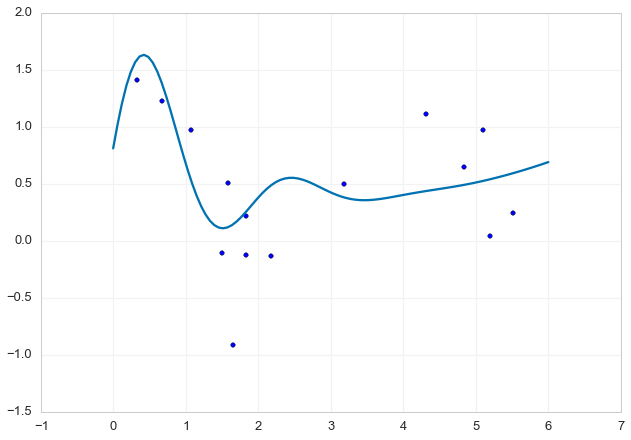

In [155]:
x, y, dy = make_fake_data()
xx = np.linspace(0, 6, 100)
plt.plot(xx, fake_func(xx))
plt.scatter(x, y)

We do need to create a matrix of the variables though:

In [156]:
X = x[:, np.newaxis]

For plotting below I also need a variable covering the xaxis - I'll call this `xplot`.

In [157]:
xplot = np.linspace(0, 6, 100)
Xplot = xplot[:, np.newaxis]

## Standard linear regression

Of course this is not going to be very nice - the data are clearly not linear.

In [158]:
from astroML.linear_model import LinearRegression

In [159]:
# Create the model
model = LinearRegression()

# Run the fit
res = model.fit(X, y)

# And predict the y-values & print the best-fit coefficients
y_pred = model.predict(X)
yplot = model.predict(Xplot)

print "Fit results: ", res.coef_

Fit results:  [ 0.4669424  -0.01079112]


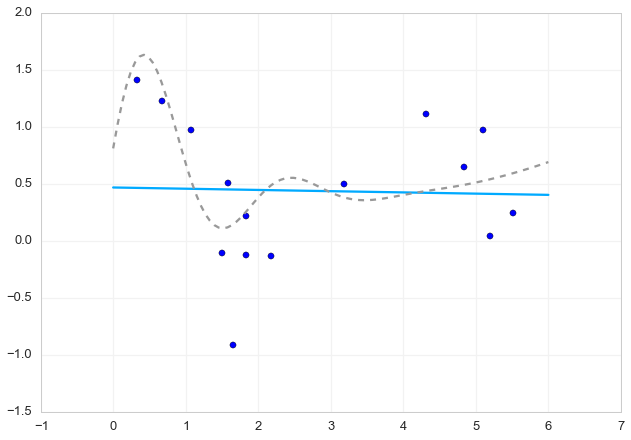

In [160]:
plot_a_fit(x, y, xplot, yplot, include_true=True)

## Ridge and LASSO regression

The situation will be much the same with these in the default setting. Because the amount of data also is quite limited I will not bother with a rigorous choice for $\lambda$.

In [161]:
from sklearn.linear_model import Ridge, Lasso

In [162]:
# Create the models
ridge_model = Ridge(fit_intercept=True, alpha=0.05)
lasso_model = Lasso(fit_intercept=True, alpha=0.05)

# Run the fit
res_ridge = ridge_model.fit(X, y)
res_lasso = lasso_model.fit(X, y)

# And predict the y-values & print the best-fit coefficients
y_pred_ridge = ridge_model.predict(X)
yplot_ridge = ridge_model.predict(Xplot)

y_pred_lasso = lasso_model.predict(X)
yplot_lasso = lasso_model.predict(Xplot)

print "Ridge: a={0} b={1}\nLASSO: a={2} b={3}".format(res_ridge.intercept_, res_ridge.coef_[0],
                                                res_lasso.intercept_, res_lasso.coef_[0])

Ridge: a=0.466909991366 b=-0.0107791962423
LASSO: a=0.437619056413 b=-0.0


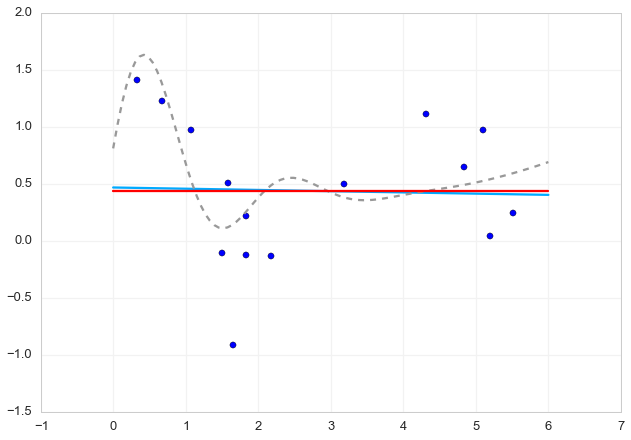

In [163]:
plot_a_fit(x, y, xplot, yplot_ridge, include_true=True)
plt.plot(xplot, yplot_lasso, 'r')

Here we can clearly see the effect of varying the regularisation parameter.

## Introducing a different basis

This example uses a fixed set of 100 Gaussians spread evenly over the x-axis.

In [164]:
def gaussian_basis(x, mu, sigma):
    return np.exp(-0.5 * ((x - mu) / sigma) ** 2)

centers = np.linspace(0, 6, 100)
widths = 0.2
Xg = gaussian_basis(x[:, np.newaxis], centers, widths)

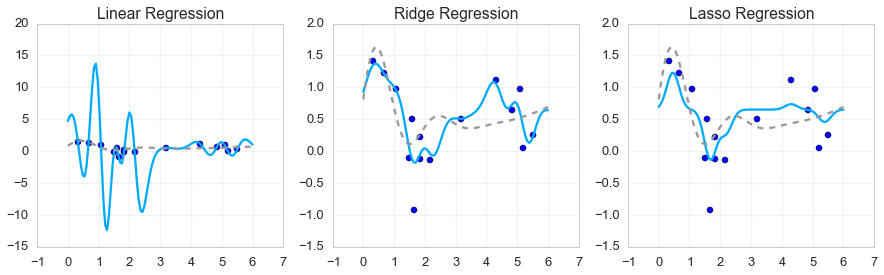

In [165]:
# Based on http://www.astroml.org/book_figures/chapter8/fig_rbf_ridge_mu_z.html

classifier = [LinearRegression, Ridge, Lasso]
kwargs = [dict(), dict(alpha=0.5), dict(alpha=0.025)]
labels = ['Linear Regression', 'Ridge Regression', 'Lasso Regression']

fig = plt.figure(figsize=(15, 4))

for i in range(3):
    clf = classifier[i](fit_intercept=True, **kwargs[i])
    clf.fit(Xg, y)
    w = clf.coef_
    tmp = gaussian_basis(xplot[:, None], centers, widths)
    yplot = clf.predict(tmp)

    ax = fig.add_subplot(131+i)
    plot_a_fit(x, y, xplot, yplot, include_true=True, ax=ax)
    ax.set_title(labels[i])

So this shows that when you have a lot of variables and not so much data, ridge regression or lasso regression might be very interesting options. The next step would then be to plot the weights. If you extend this example with the code from the URL listed above, you can do this - see it as a bit of home-work if you wish :)

# Local regression

Let us now turn to some local regression examples. This will use three different methods.

## Fitting with k-nearest neighbors regression

In this case, when we want to estimate the value of a function at $x$ we find the $k$-closest neighbours in the training sample ${x_i}$ and estimate $\hat{y} = \frac{1}{k} \sum_{x_j \in \text{Neighbours}(x; k)} y_j$. Or in words, we estimate the value by taking the average of the $y_j$ values of the k points closest to $x$.

This is straightforward and can be done using `sklearn.neighbors` as follows:

In [166]:
from sklearn import neighbors

In [167]:
k = 3
knn = neighbors.KNeighborsRegressor(k)
yplot_knn = knn.fit(X, y).predict(Xplot)

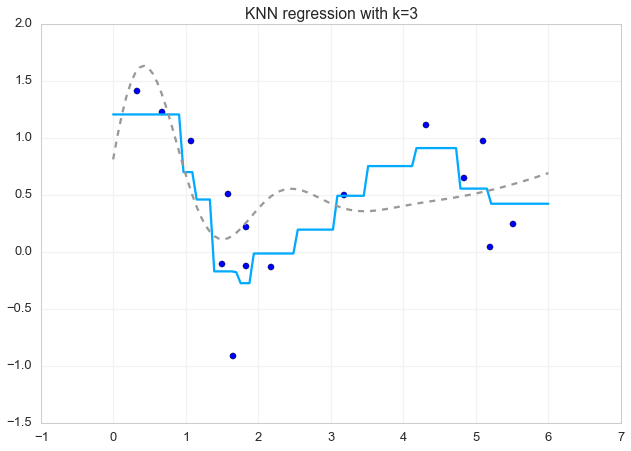

In [168]:
plot_a_fit(x, y, xplot, yplot_knn, include_true=True)
plt.title('KNN regression with k={0}'.format(k))

You might (fairly enough!) feel that this is unnecessarily discontinuous - it does not look particularly useful like this. Part of the problem is of course that all points in the neighbourhood has equal weight. Thus one possible modification is to calculate a weighted average where the weights are inversely proportional to the distance between $x_i$ and $x$ (you can also pass in a user defined function). I do not like it very much personally

To do this you set the weights argument to `KNeighborsRegressor`:

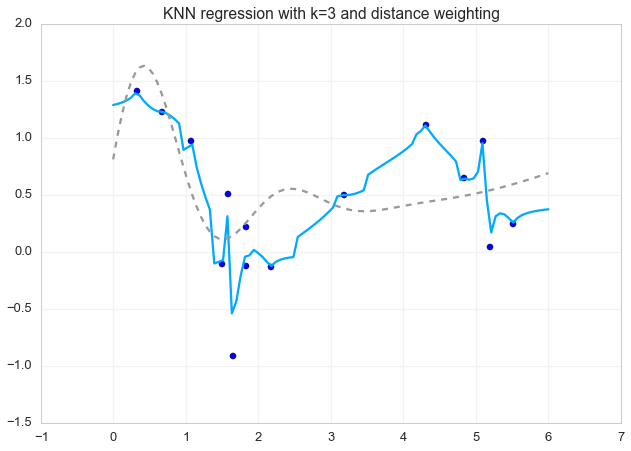

In [169]:
k = 3
knn = neighbors.KNeighborsRegressor(k, weights='distance')
yplot_knn = knn.fit(X, y).predict(Xplot)
plot_a_fit(x, y, xplot, yplot_knn, include_true=True)
plt.title('KNN regression with k={0} and distance weighting'.format(k))

# Kernel regression

The natural modification of nearest neighbour is to include all points with a weight given by a function known as the *kernel*. Since we calculate a mean with this function as weight, this is known as a kernel-weighted average.

The most widely used version is the so-called Nadaraya-Watson kernel weighted average. This is defined as

$$\hat{y}(x) = \frac{\sum_{i=1}^N K_h\left(x, x_i\right) y_i}{\sum_{i=1}^N K_h\left(x, x_i\right)} $$

where the sums are over the training sample $\{x_i, y_i\}$. The $K_h(\cdot)$ function is a kernel function - just like what we had when we were doing the kernel density estimation.  $h$ here is the band-width of the kernel - for the implementation in Python this is constant but it could also be adjusted by the local density. 

The kernel function can be chosen relatively widely. You will mostly see the Gaussian and Epanechnikov kernels but as far as I know the standard implementation in `astroML` does not provide the Epanechnikov kernel, and frankly only the gaussian works well although other kernels should be possible.

In [170]:
from astroML.linear_model import NadarayaWatson

In [171]:
sigma = 0.6
model = NadarayaWatson('gaussian', np.asarray(sigma))
model.fit(X, y)
yplot_NW = model.predict(Xplot)

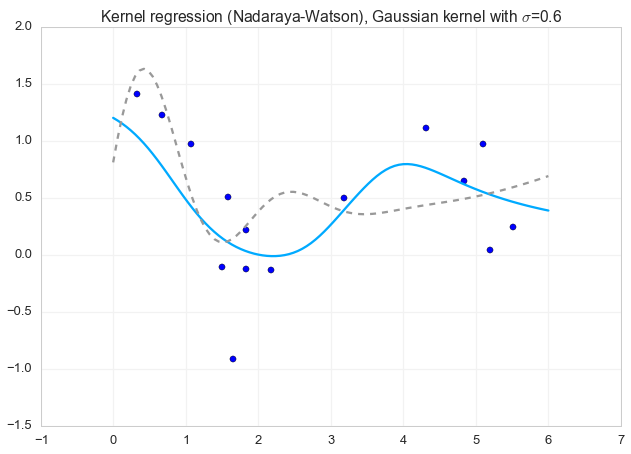

In [172]:
plot_a_fit(x, y, xplot, yplot_NW, include_true=True)
plt.title('Kernel regression (Nadaraya-Watson), Gaussian kernel with $\sigma$={0:0.1f}'.format(sigma))

As usual the bandwidth can be estimated using cross-validation. 

This provides a possible smoother - when the band-width goes to small values it approaches the k-nearest regression version with a distance weighted average.

## Locally linear regression

One problem with kernel regression estimate is that it can be severely biased at the edge of the domain. To remove this one can move to locally linear regression. This basically works like kernel regression, but in this case we fit a linear regression model at each output point, weighted by a kernel.

That might sound like a bit of hassle perhaps but it is very powerful. To understand how it works, consider a point $x_0$. We can calculate the distance to each point in our training sample $d_i = |x_0-x_i|$. This is then normalised by the band-width to give the variable

$$t_i = \frac{d_i}{h} $$

the literature sometimes use $\lambda$ for the band-width. Given this $t_i$ we can assign a weight to each point in the training set, $w_i=1/t_i$ could work for instance, except for the fact that it blows up when $x_0$ approaches $x_i$. The standard choice for the locally linear regression method known as the loess/lowess is to use a weight function (or kernel function) called the tri-cube function:

$$w_i = (1-|t_i|^3)^3 \; I(|t| \le 1)$$

where $I(\cdot)$ is the indicator function which is 1 when the argument is true and 0 otherwise. The function then looks like

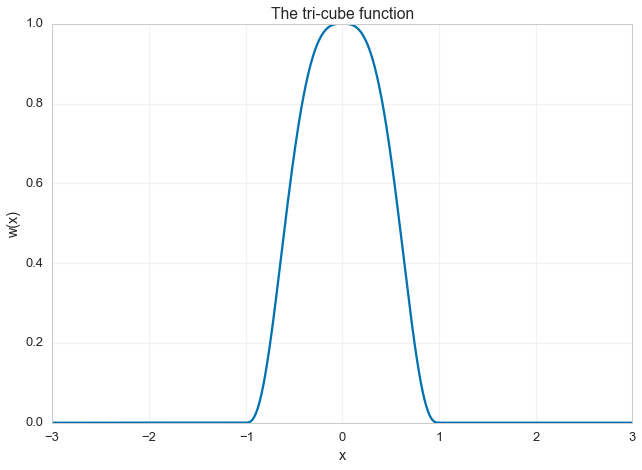

In [173]:
xx = np.linspace(-3,3,1000)
plt.plot(xx, (1-np.abs(xx)**3)**3*(np.abs(xx) <= 1))
plt.xlabel('x')
plt.ylabel('w(x)')
plt.title('The tri-cube function')

An advantage of this function is the fact that it has compact support (only a finite range in $x$ will contribute to the calculation. 

Now, from this discussion it should be clear that the local linear regression is a cool idea. However as Python implementations I am not aware of any that really are regressors (ie. can be used to predict $y$ at arbitrary $x$ values - instead they are smoothers of the data and give predictions at the $x_i$ values of the training set. This is still very useful though! So let us have a look at this and I'll come back to the regressors afterwards.

The packages that exist is `lowess` in `statsmodels` and a separate Cython package called `cylowess` (https://github.com/livingsocial/cylowess - can be installed with pip install cylowess). cylowess seems the better option from my limited use. I will first show the use on the data above.

In [174]:
from statsmodels.nonparametric.smoothers_lowess import lowess as sm_lowess
import cylowess

In [175]:
c_lowess = cylowess.lowess

The two functions have a very similar calling interface and give similar results so I will plot only one:

In [176]:
res_c = c_lowess(y,x)
res_sm = sm_lowess(y, x)

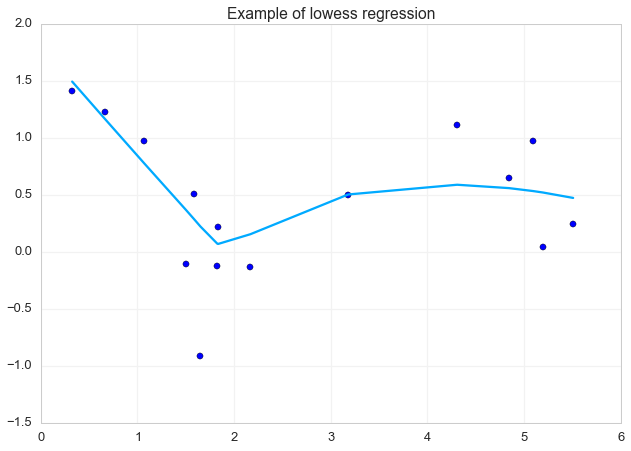

In [177]:
plot_a_fit(x, y, res_c[:, 0], res_c[:, 1])
plt.title('Example of lowess regression')

Ok, that is not that interesting - to really see the advantage of lowess smoothing it is necessary with more points - and noisy ones. So here are some with a lot of noise that is very much not Gaussian. I'll call it here with two different bandwidths (given as frac - the fraction of points to use):

In [178]:
x_noisy = np.random.uniform(low = -2*np.pi, high = 2*np.pi, size=500)
y_noisy = np.sin(x_noisy) + +stats.t.rvs(2.5, size=len(x_noisy))

# Run lowess smoothing:
res_noisy_0p1 = c_lowess(y_noisy, x_noisy, frac=0.1)
res_noisy_0p3 = c_lowess(y_noisy, x_noisy, frac=0.3)

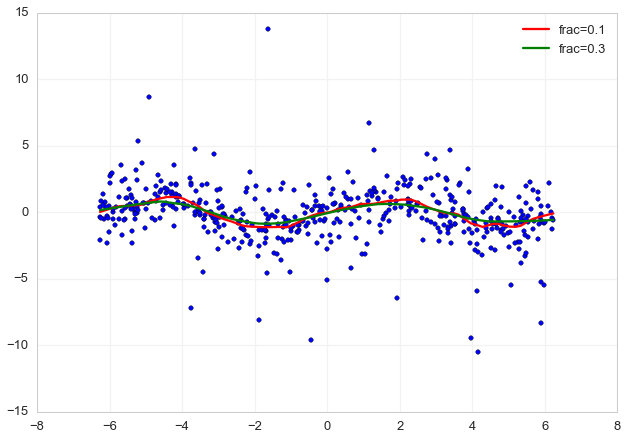

In [179]:
plt.scatter(x_noisy, y_noisy)
plt.plot(res_noisy_0p1[:, 0], res_noisy_0p1[:, 1], 'r-', label='frac=0.1')
plt.plot(res_noisy_0p3[:, 0], res_noisy_0p3[:, 1], 'g-', label='frac=0.3')
plt.legend()

In fact this way to indicate the local trend of the data is so common that the `seaborn` plotting package provides a direct way to do this:

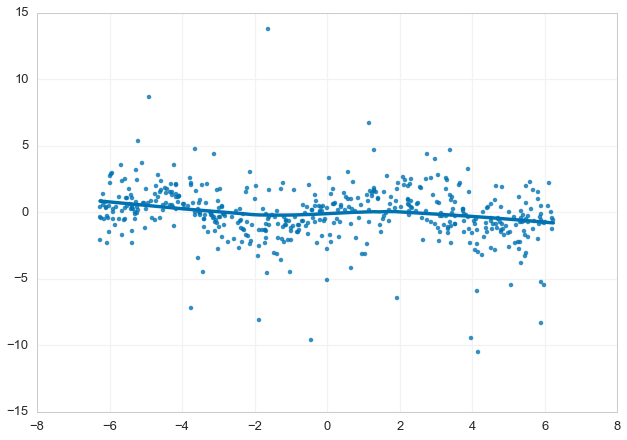

In [180]:
sns.regplot(x_noisy, y_noisy, lowess=True)

Ok, but what if you actually wanted to use this for regression to predict values at other points than your training sample. Well, at the moment you either have to move to R - there is a package called `locfit` in R which is excellent for this kind of work and personally what I use.

Or you can roll your own little code. Here is the basic structure and an example implementation:

Loop over the `x_out` data. We here do:
1. Calculate the distance to each point and select the N_each closest points (there are fast ways to do this but do not worry about this).
2. Calculate the weight for each point.
3. Run a weighted linear regression
4. Estimate y at this x value.

I would suggest using a Gaussian weighting function and use all points (ie. ignore the frac option in the routines above).

In [181]:
def tricube(t):
    """
    The tricube function
    """
    
    return (1-np.abs(t)**3)**3*(np.abs(t) <= 1)

def jb_local_linreg(x, y, x_out, bandwidth, frac=0.1):
    """
    Calculate a local linear regression from a dataset.    
    """
    
    # The total number of points.
    N = len(x)
    
    # The output array
    y_out = np.empty(len(x_out))
    y_out.fill(np.nan)
    
    # The number of points to consider for each regression.
    N_each = np.ceil(frac*N)
    
    # Loop over the x_out data. We here do:
    #   1. Calculate the distance to each point and select the 
    #      N_each closest points (there are _much_ faster ways to do this!)
    #   2. Calculate the weight for each point.
    #   3. Run a weighted linear regression
    #   4. Estimate y at this x vlaue.
    
    
    for i in range(len(x_out)):
        
        this_xout = x_out[i]
        
        # 1. Calculate the distances and choose the N_each closest
        dist = np.abs(this_xout-x)
        si = np.argsort(dist)
        use = si[0:N_each]
        x_fit = x[use]
        y_fit = y[use]
        
        # 2. Calculate the weights
        t = dist[use]/bandwidth
        weights = np.exp(-dist[use]/(2.0*bandwidth))#tricube(t)
        
        # 3. Run the weighted linear regression - note that some weights
        # might be zero so I will ignore those.
        keep, = np.where(weights > 0)
        if len(keep) > 2:
            x_fit = x_fit[keep]
            y_fit = y_fit[keep]
            weights = weights[keep]
            
            X = sm.add_constant(x_fit)
            mod_wls = sm.WLS(y_fit, X, weights=weights)
            res = mod_wls.fit()
            p = res.params
            y_out[i] = p[0] + p[1]*this_xout

    return y_out
                       

/Users/jarle/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:38: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


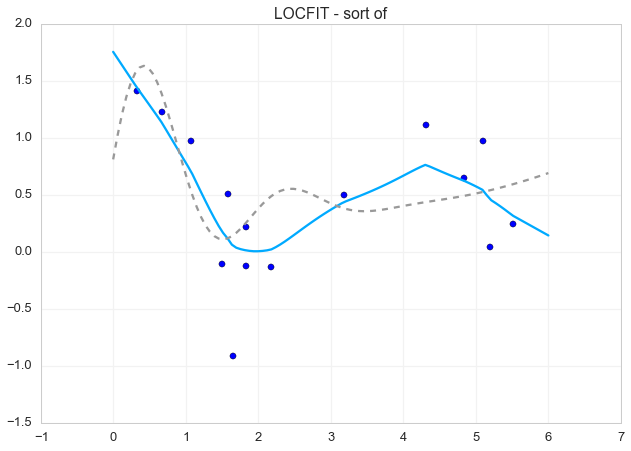

In [182]:
yplot = jb_local_linreg(x, y, xplot, 0.3, frac=1.0)
plot_a_fit(x, y, xplot, yplot, include_true=True)
plt.title('LOCFIT - sort of ')

# Gaussian process regression

Gaussian processes are formally defined to be _a collection of random variables, any Gaussian process finite number of which have a joint Gaussian distribution._, but that might not be terribly informative until you have thought about it for a while.

I personally find this rather abstract. But if we ignore the details, what this says that if I have a set of points, I can generate a function by drawing realisations from a multi-variate Gaussian with a covariance function that we need to specify and normally set to have a mean of zero.

The most commonly used covariance function is what is called the squared exponential in this area, defined through

$$\text{Cov}\left (x, x^\prime\right) = K(x, x^\prime) = \exp\left(-\frac{\left|x-x^\prime\right|}{2h} \right) $$

It is now straight forward to draw random functions with this covariance function. We simply draw from a multivariate Gaussian with mean of zero with the covariance function. To follow the notation of Rasmussen & Williams we say that the values of the function are drawn from $N(0, K(X_*, X_*))$, where $X_*$ are the test sample, or rather the x-values where we want to evaluate the function. This covariance function provides the prior on the functions we will explore. See the dedicated notebook on Gaussian processes for some more insight into this process. 

Here I will just focus on the use of the GP regression.

In [183]:
from sklearn.gaussian_process import GaussianProcess
    

In [184]:
gp = GaussianProcess(corr='squared_exponential', theta0=0.1, thetaL=1e-2,
                    thetaU=1, normalize=False, nugget=(dy/y)**2, random_start=1)

In [185]:
g = gp.fit(X, y)

In [186]:
y_pred_GP, MSE = gp.predict(Xplot, eval_MSE=True)
sigma = np.sqrt(MSE)

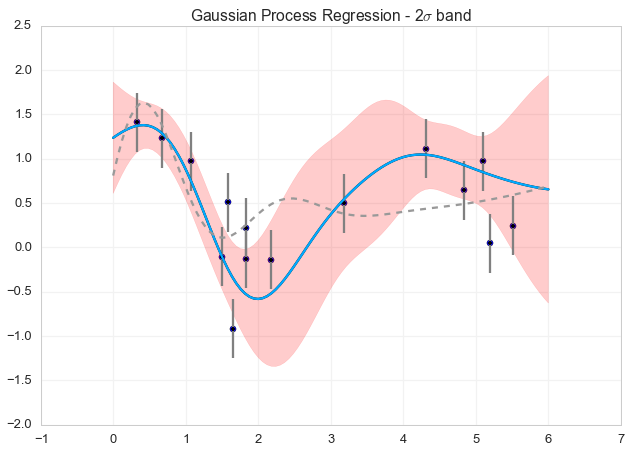

In [187]:
plot_a_fit(x, y, xplot, y_pred_GP, dy=dy, dyest=sigma, include_true=True)
plt.title('Gaussian Process Regression - 2$\sigma$ band')